In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Transformador para codificar únicamente las columnas categóricas y devolver un DataFrame
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse=False)
        self._columns = None

    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)


In [3]:
# Transformador que prepara todo el conjunto de datos llamando pipelines y transformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None

    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy="median")),
            ('rbst_scaler', RobustScaler()),
        ])
        self._full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, 
                            columns=self._columns, 
                            index=X_copy.index)

In [5]:
# Cargar el archivo CSV generado
data = pd.read_csv('Rendimiento_de_estudiantes_extendido.csv')

# Mostrar un resumen del conjunto de datos
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Hours Studied                     40000 non-null  int64 
 1   Previous Scores                   40000 non-null  int64 
 2   Extracurricular Activities        40000 non-null  object
 3   Sleep Hours                       40000 non-null  int64 
 4   Sample Question Papers Practiced  40000 non-null  int64 
 5   Performance Index                 40000 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 1.8+ MB


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91
1,4,82,No,4,2,65
2,8,51,Yes,7,2,45
3,5,52,Yes,5,2,36
4,7,75,No,8,5,66


In [6]:
# Separar características y variable objetivo
X = data.drop(columns=['Previous Scores'])
y = data['Previous Scores']

# Preprocesar los datos
preparer = DataFramePreparer()
X_prepared = preparer.fit_transform(X)

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X_prepared, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [8]:
# Entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [9]:
# Evaluar el modelo en el conjunto de validación
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

In [10]:
# Mostrar los resultados de validación
print(f"Validación - MSE: {val_mse}, R2: {val_r2}")

Validación - MSE: 3.951240677509941, R2: 0.9869357954932221


In [11]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Mostrar los resultados finales
print(f"Prueba - MSE: {test_mse}, R2: {test_r2}")

Prueba - MSE: 3.909829513300669, R2: 0.9868625946434354


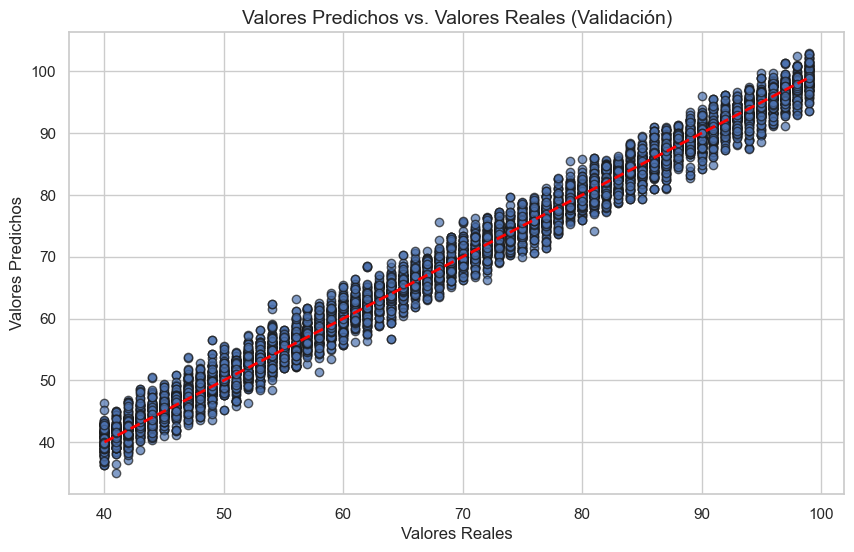

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set(style="whitegrid")

# 1. Valores predichos vs. valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.7, edgecolor='k')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', lw=2, linestyle='--')
plt.title("Valores Predichos vs. Valores Reales (Validación)", fontsize=14)
plt.xlabel("Valores Reales", fontsize=12)
plt.ylabel("Valores Predichos", fontsize=12)
plt.show()

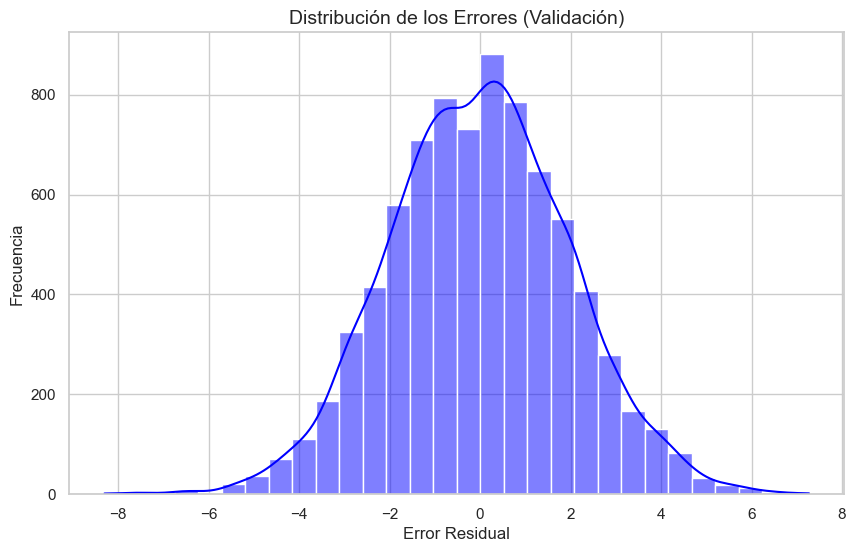

In [14]:
# 2. Distribución de los errores
residuals = y_val - y_val_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title("Distribución de los Errores (Validación)", fontsize=14)
plt.xlabel("Error Residual", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.show()

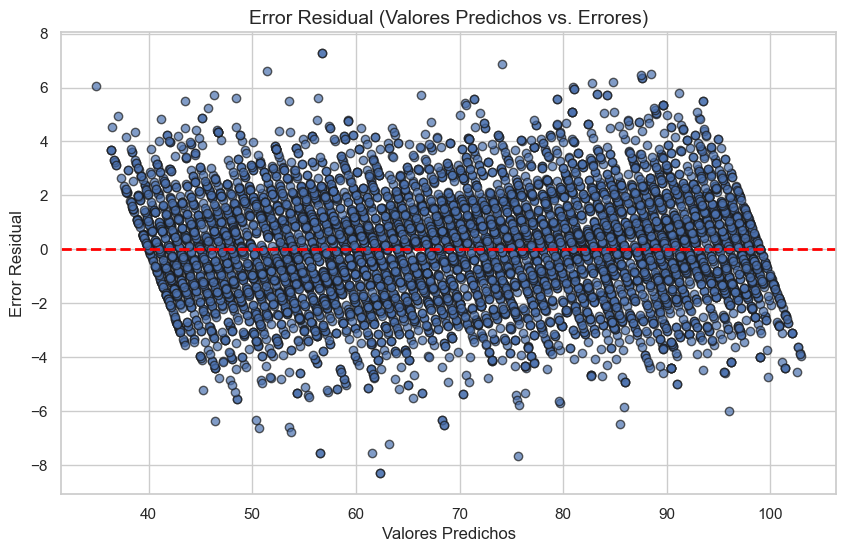

In [15]:
# 3. Gráfico de Error Residual
plt.figure(figsize=(10, 6))
plt.scatter(y_val_pred, residuals, alpha=0.7, edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.title("Error Residual (Valores Predichos vs. Errores)", fontsize=14)
plt.xlabel("Valores Predichos", fontsize=12)
plt.ylabel("Error Residual", fontsize=12)
plt.show()
